In [ ]:
using LinearAlgebra, Plots


In [ ]:
# First, let's make our particle mutable so we can update position/velocity
mutable struct ChargedParticle
    mass::Float64
    charge::Float64
    position::Vector{Float64}
    velocity::Vector{Float64}
end


In [ ]:
# Function to calculate force on particle in E and B fields
function lorentz_force(particle::ChargedParticle, E::Vector{Float64}, B::Vector{Float64})
    F_electric = particle.charge * E
    F_magnetic = particle.charge * cross(particle.velocity, B)
    return F_electric + F_magnetic
end


lorentz_force (generic function with 1 method)

In [ ]:
# Calculate acceleration from force
function get_acceleration(particle::ChargedParticle, E::Vector{Float64}, B::Vector{Float64})
    force = lorentz_force(particle, E, B)
    return force / particle.mass
end


get_acceleration (generic function with 1 method)

_Verlet integration_ is a numerical method used to integrate Newton's equations of motion.
1. set $\mathbf{x}_1=\mathbf{x}_0+\mathbf{v}_0 \Delta t+\frac{1}{2} \mathbf{A}\left(\mathbf{x}_0\right) \Delta t^2$
2. for $n=1,2, \ldots$ iterate 
$\mathbf{x}_{n+1}=2 \mathbf{x}_n-\mathbf{x}_{n-1}+\mathbf{A}\left(\mathbf{x}_n\right) \Delta t^2$

In [ ]:
# Update particle state using velocity Verlet algorithm
function update_particle!(particle::ChargedParticle, E::Vector{Float64}, B::Vector{Float64}, dt::Float64)
    # Store initial acceleration
    a_0 = get_acceleration(particle, E, B)

    # Update position using current velocity and acceleration
    particle.position += particle.velocity * dt + 0.5 * a_0 * dt^2

    # Get new acceleration at updated position
    a_1 = get_acceleration(particle, E, B)

    # Update velocity using average of accelerations
    return particle.velocity += 0.5 * (a_0 + a_1) * dt
end


update_particle! (generic function with 1 method)

In [ ]:
# Simulate particle motion for multiple timesteps
function simulate_particle_motion!(
        particle::ChargedParticle,
        E::Vector{Float64},
        B::Vector{Float64},
        total_time::Float64,
        dt::Float64
    )
    n_steps = Int(round(total_time / dt))

    # Preallocate arrays for trajectory
    trajectory = zeros(Float64, (n_steps + 1, 3))
    velocities = zeros(Float64, (n_steps + 1, 3))
    times = zeros(Float64, n_steps + 1)

    # Store initial state
    trajectory[1, :] = particle.position
    velocities[1, :] = particle.velocity
    times[1] = 0.0

    # Time evolution
    for i in 1:n_steps
        update_particle!(particle, E, B, dt)

        # Store state
        trajectory[i + 1, :] = particle.position
        velocities[i + 1, :] = particle.velocity
        times[i + 1] = i * dt
    end

    return times, trajectory, velocities
end


simulate_particle_motion! (generic function with 1 method)

In [ ]:
# Example usage:
# Create an electron
electron = ChargedParticle(
    9.1093837015e-31,  # mass in kg
    -1.602176634e-19,  # charge in coulombs
    [0.0, 0.0, 0.0],   # initial position
    [1.0e5, 0.0, 0.0]    # initial velocity (100 km/s in x direction)
)

# Set up fields (uniform magnetic field in z direction)
E = [0.0, 0.0, 0.0]        # No electric field
B = [0.0, 0.0, 1.0]        # 1 Tesla magnetic field in z direction

# Simulation parameters
total_time = 1.0e-9 # 1 nanosecond
dt = 1.0e-11        # 10 picosecond timesteps

# Run simulation
times, positions, velocities = simulate_particle_motion!(electron, E, B, total_time, dt);


([0.0, 1.0e-11, 2.0e-11, 3.0e-11, 4.0e-11, 4.9999999999999995e-11, 6.0e-11, 6.999999999999999e-11, 8.0e-11, 9.0e-11  …  9.1e-10, 9.199999999999999e-10, 9.3e-10, 9.399999999999999e-10, 9.5e-10, 9.6e-10, 9.7e-10, 9.8e-10, 9.899999999999999e-10, 9.999999999999999e-10], [0.0 0.0 0.0; 1.0e-6 8.794100053860814e-7 0.0; … ; -1.4768125776386382e24 2.9097550873778296e23 0.0; -1.9885861250512607e24 -2.306472004973072e24 0.0], [100000.0 0.0 0.0; 100000.0 175882.0010772163 0.0; … ; -1.576663392092542e35 -1.2109139515787154e35 0.0; 5.531162972672967e34 -3.9839810758429954e35 0.0])

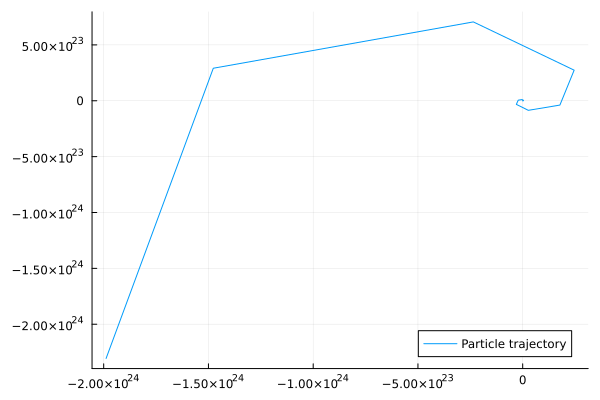

In [ ]:
# You could plot the results with Plots.jl:
plot(positions[:, 1], positions[:, 2], label = "Particle trajectory")
